In [1]:
import pandas as pd
import numpy as np
import re
import string
import time
from datetime import datetime
from datetime import date
import os

#Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# ML Libraries
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import metrics

# Save model
import pickle
import joblib

In [47]:
# fileLocation = 'C:\\Users\\VictorY\\Desktop\\TestData\\stage3FinalProcessedDF_Nov-17-2019.csv'
moviesDataFileLocation = 'C:\\Yuva\\ITU\\4th Sem\\Thesis\\Data\\Final_Data_Movies_Directors_old.csv'
saveFileToPath = "C:\\Yuva\\ITU\\4th Sem\\Thesis\\Data\\"

movies_data = pd.read_csv(moviesDataFileLocation)

In [48]:
movies_data.head(3)

,director_ids,director_names,movie_id,title,review_count_user,review_count_critic,rating_value,rating_count,date_published,release_date,movie_year,birthYear,primaryProfession,knownForTitles,Gender
0,nm0005690,William K.L. Dickson,tt0000001,Carmencita - spanyol tánc (1894) - IMDb,12,2,5.8,1255,1894-03-10,10 March 1894 (USA) See more »,1894,1860,"cinematographer,director,producer","tt0219560,tt6687694,tt1428455,tt1496763",Male
1,nm0721526,Émile Reynaud,tt0000002,A bohóc és kutyái (1892) - IMDb,0,0,6.5,148,1892-10-28,28 October 1892 (France) See more »,1892,1844,director,"tt2184231,tt0000003,tt2184201,tt0413219",Male
2,nm0721526,Émile Reynaud,tt0000003,Szegény Pierrot (1892) - IMDb,12,5,6.6,819,1892-10-28,28 October 1892 (France) See more »,1892,1844,director,"tt2184231,tt0000003,tt2184201,tt0413219",Male


In [49]:
movies_data.describe()

,review_count_user,review_count_critic,rating_value,rating_count,movie_year,birthYear
count,325375.000000,325375.000000,325375.000000,3.253750e+05,325375.000000,325375.000000
mean,8.148693,4.953085,6.836027,1.865055e+03,1985.417269,1941.103139
std,61.496919,25.882580,1.302666,2.163975e+04,25.184835,27.455184
min,0.000000,0.000000,1.000000,5.000000e+00,1887.000000,6.000000
25%,0.000000,0.000000,6.100000,1.100000e+01,1968.000000,1922.000000
50%,0.000000,0.000000,7.000000,3.000000e+01,1992.000000,1944.000000
75%,2.000000,1.000000,7.800000,1.270000e+02,2007.000000,1963.000000
max,5075.000000,815.000000,10.000000,1.741951e+06,2017.000000,2004.000000


In [50]:
# Function to Plot - Distribution of rating value among male and female. 

def plot_features_WRT_gender(df,columnCriteriaName,columnFeatureName):
    dict={}
    for i in df[columnCriteriaName].value_counts().index:
        dict["{0}_{1}".format(columnFeatureName,i)] = df[(df[columnCriteriaName] == i)][columnFeatureName]
    for k,v in dict.items():
        sns.distplot(v,label=[k])
        plt.legend(bbox_to_anchor=(1.05, 0.6), loc=2, borderaxespad=0.)

Rating count vs gender has almost the same distribution. 
Hence the prediction of Gender based on rating count is not feasible

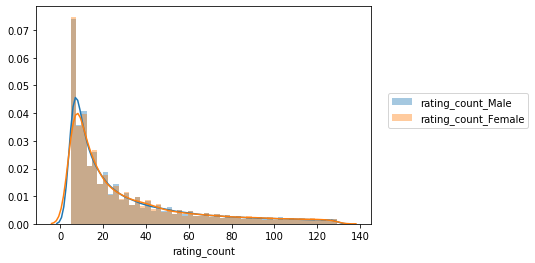

In [51]:
plot_features_WRT_gender(movies_data[movies_data.rating_count<130],"Gender","rating_count")

# Why continue predicting Gender when the distributions are not separable?

Rating Value vs gender has almost the same distribution. 
Hence the prediction of Gender based on rating count is not feasible

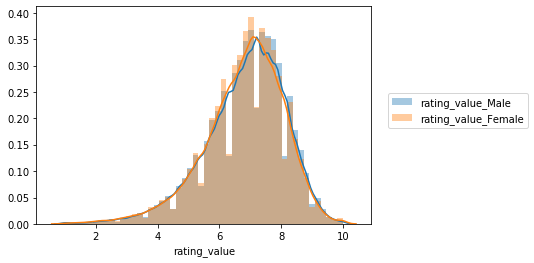

In [52]:
plot_features_WRT_gender(movies_data,"Gender","rating_value")

In [53]:
movies_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325375 entries, 0 to 325374
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   director_ids         325375 non-null  object 
 1   director_names       325375 non-null  object 
 2   movie_id             325375 non-null  object 
 3   title                325375 non-null  object 
 4   review_count_user    325375 non-null  int64  
 5   review_count_critic  325375 non-null  int64  
 6   rating_value         325375 non-null  float64
 7   rating_count         325375 non-null  int64  
 8   date_published       325375 non-null  object 
 9   release_date         325375 non-null  object 
 10  movie_year           325375 non-null  int64  
 11  birthYear            325375 non-null  int64  
 12  primaryProfession    325375 non-null  object 
 13  knownForTitles       325375 non-null  object 
 14  Gender               325375 non-null  object 
dtypes: float64(1), in

In [54]:
req_columns = ['review_count_user', 'review_count_critic','rating_value',
               'rating_count','movie_year','birthYear','Gender']

In [55]:
movies_data = movies_data[req_columns]
print('The shape of our Director specific dataset is:', movies_data.shape)

The shape of our Director specific dataset is: (325375, 7)


In [56]:
save = movies_data.copy()

# Weighted Ranking

In [57]:
movies_data = save.copy()

In [12]:
# Weighted ranking value
# IMDB uses this famous formula:
# weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C

# Where:

# R = average for the movie (mean) = (rating)

# v = number of votes for the movie = (votes)

# m = minimum votes required to be listed in the Top Rated list (currently 25,000)

# C = the mean vote across the whole report

In [67]:
(4 / (4/2))

2.0

In [68]:
(10 / (2+3))

2.0

In [70]:
(4 / (4/2)) * 2 + (15 / (2+3)) * 5

19.0

In [69]:
2 * 2 + 3 * 5

19

In [ ]:
(v ÷ (v+m)) × R + (m ÷ (v+m)) × C

In [59]:
movies_data.rating_value.median()

7.0

In [58]:
movies_data.rating_value.mean()

6.836026738378925

In [82]:
def weightedRank(df,R='rating_value', v='rating_count', m = 0):
    df = df.loc[df[v] > m ]
    df['weighted_rank'] = (df[v] / (df[v] + m )) * df[R] + (m / ( df[v] + m)) * movies_data.rating_value.mean()
    return df

In [83]:
# movies_data['weightedRank'] = weightedRank(movies_data)

movies_data = weightedRank(movies_data,m=1000)

C:\Users\yuvar\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [84]:
movies_data['diff'] = movies_data['rating_value'] - movies_data['weighted_rank']

C:\Users\yuvar\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [85]:
movies_data = movies_data.sort_values(by = 'diff',ascending= False)
movies_data

,review_count_user,review_count_critic,rating_value,rating_count,movie_year,birthYear,Gender,weighted_rank,diff
314197,2,1,9.6,1035,2015,1979,Male,8.241782,1.358218
316683,1,1,9.6,1082,2016,1967,Male,8.272443,1.327557
263632,2,5,9.5,1048,2010,1964,Male,8.199232,1.300768
299530,6,1,9.7,1213,2013,1948,Male,8.405841,1.294159
197277,12,0,9.5,1088,2006,1962,Male,8.224151,1.275849
...,...,...,...,...,...,...,...,...,...
105713,28,7,1.6,1151,2000,1968,Female,4.034229,-2.434229
97713,0,1,1.5,1173,1992,1965,Male,3.955604,-2.455604
106888,43,5,1.7,1051,2000,1969,Male,4.204157,-2.504157
46975,32,4,1.8,1002,1976,1917,Male,4.315498,-2.515498


In [45]:
movies_data.count()

review_count_user      25192
review_count_critic    25192
rating_value           25192
rating_count           25192
movie_year             25192
birthYear              25192
Gender                 25192
weighted_rank          25192
diff                   25192
dtype: int64

In [152]:
movies_data[['rating_value','weighted_rank']].describe()

,rating_value,weighted_rank
count,3894.000000,3894.000000
mean,6.852414,6.887837
std,1.001826,0.726922
min,1.600000,2.916709
25%,6.300000,6.454359
50%,6.900000,6.894178
75%,7.600000,7.367194
max,10.000000,9.427223


In [153]:
# Quartile cut into 4 different buckets

bin_quartiles = ['poor','average','good','excellent']
cutIntoQuartiles = pd.qcut(movies_data['weighted_rank'].to_list(), q=4,labels=bin_quartiles)

# Print the quartile range for visuals
print(cutIntoQuartiles.categories)

# Add the data to the dataframe
movies_data['calc_score'] = cutIntoQuartiles

Index(['poor', 'average', 'good', 'excellent'], dtype='object')


## Rating Value quartile buckets

In [154]:
# # Quartile cut into 4 different buckets

# bin_quartiles = ['poor','average','good','excellent']
# cutIntoQuartiles = pd.qcut(movies_data['rating_value'].to_list(), q=4,labels=bin_quartiles)

# # Print the quartile range for visuals
# print(cutIntoQuartiles.categories)

# # Add the data to the dataframe
# movies_data['calc_score'] = cutIntoQuartiles

In [155]:
movies_data.describe()

,review_count_user,review_count_critic,rating_value,rating_count,movie_year,birthYear,weighted_rank
count,3894.000000,3894.000000,3894.000000,3.894000e+03,3894.000000,3894.000000,3894.000000
mean,371.420904,179.094248,6.852414,1.248025e+05,1999.181305,1953.839240,6.887837
std,408.922802,120.427367,1.001826,1.536742e+05,15.545431,17.629295,0.726922
min,17.000000,1.000000,1.600000,2.500500e+04,1902.000000,1861.000000,2.916709
25%,149.000000,93.000000,6.300000,3.969150e+04,1994.000000,1945.000000,6.454359
50%,245.000000,152.000000,6.900000,7.042600e+04,2004.000000,1958.000000,6.894178
75%,437.750000,232.000000,7.600000,1.438155e+05,2010.000000,1966.000000,7.367194
max,5075.000000,815.000000,10.000000,1.741951e+06,2016.000000,1989.000000,9.427223


In [156]:
movies_data['calc_score'].value_counts()

good         974
poor         974
excellent    973
average      973
Name: calc_score, dtype: int64

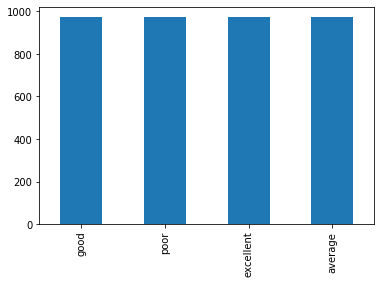

In [157]:
movies_data['calc_score'].value_counts().plot.bar()

In [158]:
movies_data.columns

Index(['review_count_user', 'review_count_critic', 'rating_value',
       'rating_count', 'movie_year', 'birthYear', 'Gender', 'weighted_rank',
       'calc_score'],
      dtype='object')

In [159]:
req_columns = ['review_count_user', 'review_count_critic', 
               'movie_year','birthYear','Gender','calc_score']
# 'rating_value',
# 'rating_value','rating_count','weighted_rank',

In [160]:
movies_data = movies_data[req_columns]

In [161]:
movies_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3894 entries, 258 to 318669
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   review_count_user    3894 non-null   int64   
 1   review_count_critic  3894 non-null   int64   
 2   movie_year           3894 non-null   int64   
 3   birthYear            3894 non-null   int64   
 4   Gender               3894 non-null   object  
 5   calc_score           3894 non-null   category
dtypes: category(1), int64(4), object(1)
memory usage: 186.5+ KB


In [162]:
movies_data.calc_score = movies_data.calc_score.astype(object)

C:\Users\yuvar\Anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [163]:
movies_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3894 entries, 258 to 318669
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   review_count_user    3894 non-null   int64 
 1   review_count_critic  3894 non-null   int64 
 2   movie_year           3894 non-null   int64 
 3   birthYear            3894 non-null   int64 
 4   Gender               3894 non-null   object
 5   calc_score           3894 non-null   object
dtypes: int64(4), object(2)
memory usage: 213.0+ KB


In [164]:
# Generic function to equally split the dataframe with respect to the column Name, in our case the Gender column.

def equal_split_on_columnName(nSampleEach, df,columnName='Gender'):
    df1 = pd.DataFrame()
    for i in df[columnName].value_counts().index:
        df1 = df1.append(df[(df[columnName]==i)].sample(n=nSampleEach,replace = False))        
    return df1.reset_index(drop=True)

In [165]:
copy = movies_data.copy()

In [166]:
# movies_data = copy.sample(n = 1000 , random_state = 42)
# movies_data = equal_split_on_columnName(5000,movies_data)

In [167]:
# one hot encoding of Gender
movies_data = pd.concat([movies_data, pd.get_dummies(movies_data.Gender,prefix='Gender')],axis=1)
movies_data.drop(['Gender'],axis=1, inplace=True)
movies_data

,review_count_user,review_count_critic,movie_year,birthYear,calc_score,Gender_Female,Gender_Male
258,156,89,1902,1861,excellent,0,1
2163,200,168,1920,1873,excellent,0,1
2570,117,84,1921,1889,excellent,0,1
2797,365,240,1922,1888,excellent,0,1
3372,181,103,1925,1898,excellent,0,1
...,...,...,...,...,...,...,...
313559,112,275,2016,1935,average,0,1
315210,99,181,2016,1975,excellent,1,0
315670,43,23,2016,1952,poor,0,1
317510,144,139,2016,1978,average,0,1


# Run SVM 

In [168]:
start = time.time()
print("Started Reading files at :" + str(datetime.utcfromtimestamp(start).strftime('%Y-%m-%d %H:%M:%S')))

Started Reading files at :2020-04-04 09:20:12


In [169]:
predictingFeature  =  ['calc_score']
featuresSelected = movies_data.columns.to_list()
featuresSelected.remove('calc_score')

In [170]:
# divide the data into attributes and labels
X = movies_data[featuresSelected]
y = movies_data[predictingFeature]

In [171]:
# Divide the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [172]:
# Training the model
# svclassifier = SVC(kernel='linear')
# svclassifier = SVC(kernel='poly', degree=4)
svclassifier = SVC(kernel='rbf',gamma='auto')
# svclassifier = SVC(kernel='sigmoid')

## Feature Selection

In [173]:
from sklearn.feature_selection import RFE

selector = RFE(svclassifier, 4, step=1)
selector = selector.fit(X, y)

C:\Users\yuvar\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RuntimeError: The classifier does not expose "coef_" or "feature_importances_" attributes

In [ ]:
selector.support_

In [63]:
selector.ranking_

array([3, 2, 1, 1, 1, 1])

Most important features

In [78]:
imp_features = selector.get_support(1) #the most important features

print("The most important features are :",movies_data.columns[imp_features].values) # final features`

The most important features are : ['movie_year' 'birthYear' 'calc_score' 'Gender_Female']


In [79]:
movies_data = movies_data[movies_data.columns[imp_features]] # final features

In [64]:
selector.score(X_train,y_train)

0.305

In [65]:
selector.score(X_test,y_test)

0.335

## SVC fitting the model

In [174]:
# Fit the model
svclassifier.fit(X_train, y_train)

C:\Users\yuvar\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [60]:
svclassifier.coef_[0]

array([-0.00508068,  0.01207052, -0.02548879, -0.00776655,  0.0137065 ,
       -0.0137065 ])

In [46]:
# # Accuracy including all features ( rating_value and rating_count and weighted_rank in Linear kernel)
# Training accuracy : 82.0
# Testing accuracy : 77.5

In [175]:
train_score_SVC = svclassifier.score(X_train, y_train)
print("Training accuracy :",train_score_SVC*100)

Training accuracy : 100.0


In [176]:
test_score_SVC = svclassifier.score(X_test, y_test)
print("Testing accuracy :",test_score_SVC*100)

Testing accuracy : 29.781771501925547


In [177]:
# Prediction based on the model trained
y_pred = svclassifier.predict(X_test)
# tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()

In [178]:
confusion_matrix(y_test,y_pred)

array([[ 16,   5,   8, 172],
       [  2,  13,   2, 180],
       [  3,   2,  21, 164],
       [  5,   2,   2, 182]], dtype=int64)

In [179]:
# Classification Report
print("\nClassification Report\n")
print(classification_report(y_test, y_pred))


Classification Report

              precision    recall  f1-score   support

     average       0.62      0.08      0.14       201
   excellent       0.59      0.07      0.12       197
        good       0.64      0.11      0.19       190
        poor       0.26      0.95      0.41       191

    accuracy                           0.30       779
   macro avg       0.53      0.30      0.21       779
weighted avg       0.53      0.30      0.21       779



In [180]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(y_test, y_pred)

0.06899821496068337

In [ ]:
def print_feature_importances(coef, names, top=-1):
    whole = []
    imp = coef
    imp,names = zip(*sorted(list(zip(imp, names)),reverse=True))
    for i in range(len(names)):
        string = "{} :: {}".format(str(names[i]),str(round(imp[i],3)))
        whole.append(string)
    return whole

In [ ]:
# Feature importance based on contribution to the classifier model
print("\nAbsolute contributions\n")
absoluteListOrder = print_feature_importances(abs(svclassifier.coef_[0]), featuresSelected)
for j in absoluteListOrder:
    print(j)

In [ ]:
# Stop timer
end = time.time()

In [ ]:
print("\nStopped Reading files at :" + str(datetime.utcfromtimestamp(end).strftime('%Y-%m-%d %H:%M:%S')))
total_time = str(round((end - start)/60,2))
print("Total time taken in minutes: " + str((end - start)/60))